# 패키지 다운로드 & 버전 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvcc -V
!echo
!gcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Wed Dec 15 07:02:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+=========

In [ ]:
!git clone https://github.com/SwinTransformer/Swin-Transformer-Object-Detection.git
!pip install -r /content/Swin-Transformer-Object-Detection/requirements.txt
!pip install openmim
!mim install mmdet
!pip install tqdm

# !git clone https://github.com/NVIDIA/apex
# %cd apex
# !pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
# %cd ..

# 데이터 다운로드 & 오류데이터 수정

In [ ]:
!unzip '/content/drive/MyDrive/input/ocr_ancient.zip' -d /content/data
# !unzip '/content/drive/MyDrive/input/train.zip' -d /content/data
# !unzip '/content/drive/MyDrive/input/valid.zip' -d /content/data

In [5]:
!cp /content/drive/MyDrive/input/train.json /content/data/train.json
!cp /content/drive/MyDrive/input/valid.json /content/data/valid.json

In [68]:
# 목판본_043_언해류_대학언해_01
# 목판본_043_언해류_대학언해1_01
# 필사본_104_문학류_대명영렬전2_01
# 필사본_104_문학류_대병영렬전2_01
# 필사본_105_문학류_대명영렬전3_01
# 필사본_105_문학류_대병영렬전3_01
import os
from glob import glob
json_list = glob(os.path.join('/content/data/이미지데이터','*')) # derectory
for i in json_list:
    tmp_list = glob(os.path.join(i,'*'))
    for j in tmp_list: # image파일

        if j.split('/')[-1][:-8] != i.split('/')[-1]:
            dir_name = i.split('/')[-1]
            img_number = j.split('/')[-1][-8:]
            os.rename(j, '/content/data/이미지데이터/'+dir_name+'/'+dir_name+img_number)

# 데이터 전처리

In [18]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random

from collections import defaultdict, Counter
import json
from glob import glob
import pycocotools

In [ ]:
!rm -rf /content/data/image

In [ ]:
# 300, 600 이상 제거하면 22165 장 데이터, 200, 400 이면

## seg없이 데이터만들기

In [ ]:
def make_dataset(mode='train'):

    os.makedirs(f'/content/data/{mode}', exist_ok=True)
    dir_list = glob('/content/data/라벨링데이터/*')

    count = 0

    image_idx = 0
    annotation_idx = 0

    images = [] # images.append({'id':image_idx, 'file_name': jf_name+'/'+jf_name+file_name[-4:]+'.png','width':d['Image_Width'], 'height':d['Image_Height']})
    annotations = [] # annotations.append({'id':annotations_idx, 'image_id':image_idx, 'category_id':0,\
                    # 'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
    for idx, i in tqdm(enumerate(dir_list)): # directory
        print(idx, i)
        dir_name = i.split('/')[-1]
        json_list = glob(os.path.join(i, '*')) # json파일
        if mode == 'train': ################################################# train, valid 비율설정
            iter = json_list[:int(len(json_list)*0.5)]
        else:
            iter = json_list[int(len(json_list)*0.8):]
        for j in iter:
            with open(j, 'r', encoding='utf-8-sig') as jfile:
                d = json.load(jfile)
                image_name = d['Image_filename']
                image_num = image_name[-4:]
                if d['Image_Char_no'] > 400:
                    continue
                
                image = plt.imread(i.replace('라벨링데이터','이미지데이터')+'/'+dir_name+image_num+'.png') # h, w, c

    #             image = np.zeros((int(d['Image_Height']), int(d['Image_Width']), 3), dtype=int)
                h,w,c = image.shape

                ### ----------------- Min, Max 계산 ----------------- ###
                min_y, max_y, min_x, max_x = 1e9, 0, 1e9, 0
                for k in d['Text_Coord']:
                    bbox = k['bbox'] # x,y,w,h
                    min_y, max_y, min_x, max_x = min(min_y, bbox[1]), max(max_y,bbox[1]+bbox[3]),\
                                                min(min_x, bbox[0]), max(max_x,bbox[0]+bbox[2])
                # 자를 지점 결과
                mini_y, maxi_y, mini_x, maxi_x = max(0,min_y-32), min(h,max_y+32), max(0,min_x-32), min(w, max_x+32)
                
                ### ----------------- 글 주변만 자른 이미지 ----------------- ###
                result = image[mini_y:maxi_y, mini_x:maxi_x,:]
                h_, w_, c_ = result.shape
                
                ### ----------------- 가운데를 자르기 전 빈 공간이 있는지 체크 ----------------- ###
                width_check = np.array([0]*w_)

                for k in d['Text_Coord']:
                    bbox = k['bbox']
                    annotate = k['annotate']
                    # pp = image[bbox[1]-mini_y:bbox[1]-mini_y+bbox[3],bbox[0]-mini_x:bbox[0]-mini_x+bbox[2],:]
                    width_check[bbox[0]-mini_x:bbox[0]-mini_x+bbox[2]] += 1
                    # rect = patches.Rectangle((bbox[0]-mini_x,bbox[1]-mini_y),bbox[2],bbox[3], linewidth=3, edgecolor='r', facecolor='none')
                    # ax.add_patch(rect)
                plt.show()
                
                ### ----------------- 빈 공간이 있으면 이미지 분할 ----------------- ###
                cutting = None
                start = None # 빈공간의 처음지점
                end = None # 빈공간의 마지막 지점 --> 치우치지 않게 자르기 위함
                flag = False
                if h_/w_ < 1.0:
                    for n in range(10, -25,-1):
                        if width_check[w_//2 + n] == 0 and flag == False:
                            start = w_//2 + n
                            end = w_//2 + n
                            flag = True
                        elif width_check[w_//2 + n] == 0 and flag == True:
                            end = w_//2 + n
                        elif width_check[w_//2 + n] != 0 and flag == True:
                            end = w_//2 + n
                            break
                        else:
                            continue
                    if start is None or end is None: # 가로가 긴데 못자르면 패스
                        continue
                        
                    cutting = (start+end)//2
                    
                    left_coord = []
                    right_coord = []
                    
                    for k in d['Text_Coord']:
                        bbox = k['bbox']
                        bbox_ = [bbox[0]-mini_x,bbox[1]-mini_y,bbox[2],bbox[3]] # 원래 bbox에서 여백제거한만큼 이동
                        if bbox_[0] > cutting:
                            bbox_[0] -= cutting
                            right_coord.append(bbox_)
                        else:
                            left_coord.append(bbox_)
                    
                    image_left = result[:,:cutting,:]
                    image_right = result[:,cutting:,:]
                    
                    h_left, w_left, _ = image_left.shape
                    h_right, w_right, _ = image_right.shape
                    if 2 > h_left / w_left >= 1: # 자른 후 세로가 길어야 저장
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_left)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_left, 'height':h_left})
                        for ann in left_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            annotation_idx += 1
                        image_idx += 1
                    if 2 > h_right / w_right >= 1:
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_right)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_right, 'height':h_right})
                        for ann in right_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            annotation_idx += 1

                        image_idx += 1
                        
                    
                else: # 세로가 길면
                    if h_/w_ > 2 or d['Image_Char_no'] > 200:
                        count += 1
                        continue
                    plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', result)
                    # fig, ax = plt.subplots(figsize=(8,8))
                    # ax.imshow(result)
                    images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                'width':w_, 'height':h_})
                    for ann in d['Text_Coord']:
                        x,y,w,h = ann['bbox'][:4]
                        if 0 > x or x+w > w_ or 0 > y or y+h > h_:
                            continue
                        annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                        rect = patches.Rectangle((x-mini_x,y-mini_y),w,h, linewidth=3, edgecolor='r', facecolor='none')
                        # ax.add_patch(rect)
                        annotation_idx += 1
                    image_idx += 1
                    # plt.show()
    return images, annotations

## seg 잇이

In [20]:
!rm -rf /content/data/train
!rm -rf /content/data/valid
!rm -rf /content/data/train.json
!rm -rf /content/data/valid.json

In [15]:
import pycocotools

In [ ]:
dir(pycocotools)

In [ ]:
dir(pycocotools.mask)

In [41]:
aa = np.zeros((30,30), np.uint8)
aa[10:20, 10:20] = 1

In [72]:
import numpy as np
from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [42]:
aa_ = np.asfortranarray(aa)

In [71]:
str(pycocotools.mask.encode(aa_)['counts'])

"b'f9:d000000000000000000R9'"

In [ ]:
!ls /content/data

이미지데이터  라벨링데이터  train  train.json


In [ ]:
glob('/content/data/이미지데이터/*')

In [13]:
def decide_min_max(coordinates : dict, h, w):
    min_y, max_y, min_x, max_x = 1e9, 0, 1e9, 0

    for i in coordinates:
        bbox = i['bbox']
        min_y, max_y, min_x, max_x = min(min_y, bbox[1]), max(max_y,bbox[1]+bbox[3]),\
                                    min(min_x, bbox[0]), max(max_x,bbox[0]+bbox[2])
    mini_y, maxi_y, mini_x, maxi_x = max(0,min_y-32), min(h,max_y+32), max(0,min_x-32), min(w, max_x+32)
    return mini_y, maxi_y, mini_x, maxi_x


def make_segmentation(x,y,w,h,image):
    base = np.zeros(image.shape[:2])
    box = image[y:y+h,x:x+w,:]
    rgb_distance = np.abs(box[:,:,0] - box[:,:,1]) + np.abs(box[:,:,1] - box[:,:,2]) + np.abs(box[:,:,2] - box[:,:,0])
    rgb_mask = np.zeros((h,w))
    for m in np.argwhere(rgb_distance < 0.7):
        rgb_mask[m[0], m[1]] = 1
    
    box_gray = np.mean(box, axis=2)
    mean_box = np.mean(box.flatten())
    under_mean = np.argwhere(box_gray <= mean_box*0.9)
    zero_arg = np.argwhere(box_gray <= np.min(box_gray.flatten())+0.01)
    tmp_mask = np.zeros((h,w))
    for m in under_mean:
        tmp_mask[m[0],m[1]] = 1
    for m in zero_arg:
        tmp_mask[m[0],m[1]] = 1
    total_mask = rgb_mask * tmp_mask
    if np.sum(total_mask.flatten()) < 4:
        return None
    base[y:y+h, x:x+w] = total_mask
    base = np.asfortranarray(base).astype(np.uint8)
    seg = pycocotools.mask.encode(base)
    seg['counts'] = seg['counts'].decode('ascii')
    # seg = np.flip(np.argwhere(total_mask==1),axis=1) + [x,y]
    return seg

In [21]:
def make_dataset(mode='train', seg_option=False, just_image=False):

    os.makedirs(f'/content/data/{mode}', exist_ok=True)
    dir_list = glob('/content/data/라벨링데이터/*')

    count = 0

    image_idx = 0
    annotation_idx = 0

    images = [] # images.append({'id':image_idx, 'file_name': jf_name+'/'+jf_name+file_name[-4:]+'.png','width':d['Image_Width'], 'height':d['Image_Height']})
    annotations = [] # annotations.append({'id':annotations_idx, 'image_id':image_idx, 'category_id':0,\
                    # 'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
    for idx, i in tqdm(enumerate(dir_list)): # directory
        print(idx, i)
        # if idx > 30:
        #     break
        dir_name = i.split('/')[-1]
        json_list = glob(os.path.join(i, '*')) # json파일
        if mode == 'train': ################################################# train, valid 비율설정
            iter = json_list[:int(len(json_list)*0.5)]
        else:
            iter = json_list[int(len(json_list)*0.8):]
        for j in iter:
            with open(j, 'r', encoding='utf-8-sig') as jfile:
                d = json.load(jfile)
                image_name = d['Image_filename']
                image_num = image_name[-4:]
                if d['Image_Char_no'] > 400:
                    continue
                
                image = plt.imread(i.replace('라벨링데이터','이미지데이터')+'/'+dir_name+image_num+'.png') # h, w, c

    #             image = np.zeros((int(d['Image_Height']), int(d['Image_Width']), 3), dtype=int)
                h,w,c = image.shape

                mini_y, maxi_y, mini_x, maxi_x = decide_min_max(d['Text_Coord'], h,w)
                
                ### ----------------- 글 주변만 자른 이미지 ----------------- ###
                result = image[mini_y:maxi_y, mini_x:maxi_x,:]
                h_, w_, c_ = result.shape

                ### ----------------- 가운데를 자르기 전 빈 공간이 있는지 체크 ----------------- ###
                width_check = np.array([0]*w_)

                for k in d['Text_Coord']:
                    bbox = k['bbox']
                    annotate = k['annotate']
                    width_check[bbox[0]-mini_x:bbox[0]-mini_x+bbox[2]] += 1
                
                ### ----------------- 빈 공간이 있으면 이미지 분할 ----------------- ###
                cutting = None
                start = None # 빈공간의 처음지점
                end = None # 빈공간의 마지막 지점 --> 치우치지 않게 자르기 위함
                flag = False
                if h_/w_ < 1.0:
                    for n in range(10, -25,-1):
                        if width_check[w_//2 + n] == 0 and flag == False:
                            start = w_//2 + n
                            end = w_//2 + n
                            flag = True
                        elif width_check[w_//2 + n] == 0 and flag == True:
                            end = w_//2 + n
                        elif width_check[w_//2 + n] != 0 and flag == True:
                            break
                        else:
                            continue
                    if start is None or end is None: # 가로가 긴데 못자르면 패스
                        continue
                        
                    cutting = (start+end)//2
                    
                    left_coord = []
                    right_coord = []
                    
                    for k in d['Text_Coord']:
                        bbox = k['bbox']
                        bbox_ = [bbox[0]-mini_x,bbox[1]-mini_y,bbox[2],bbox[3]] # 원래 bbox에서 여백제거한만큼 이동
                        if bbox_[0] >= cutting:
                            bbox_[0] -= cutting
                            right_coord.append(bbox_)
                        else:
                            left_coord.append(bbox_)
                    
                    ####################################################### 가로로 길면 분할
                    
                    image_left = result[:,:cutting,:]
                    image_right = result[:,cutting:,:]
                    
                    h_left, w_left, _ = image_left.shape
                    h_right, w_right, _ = image_right.shape
                    if 2 > h_left / w_left >= 1: # 왼쪽 이미지에 대해서 자른 후 세로가 길어야 저장
                        if h_left*w_left > 4000000: ############################################## Image
                            image_left_ = cv2.resize(image_left, (w_left//2, h_left//2)) # w, h
                            plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_left_)
                            images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                        'width':w_left//2, 'height':h_left//2})
                        else:
                            plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_left)
                            images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                        'width':w_left, 'height':h_left})
                        if just_image == True:
                            image_idx += 1
                            continue

                        if h_left*w_left > 4000000:
                            for ann in left_coord: ############################################### Annotation
                                x,y,w,h = ann[:4]
                                if 0 > x or x+w > w_left or 0 > y or y+h > h_left:
                                    continue
                                seg = None
                                if seg_option:
                                    seg = make_segmentation(x//2,y//2,w//2,h//2,image_left_)
                                    if seg is None:
                                        continue
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x//2,y//2,w//2,h//2), 'area':w//2*h//2, 'ignore':0,'iscrowd':0,'segmentation':seg})
                                else:
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                                annotation_idx += 1
                        else:
                            for ann in left_coord: 
                                x,y,w,h = ann[:4]
                                if 0 > x or x+w > w_left or 0 > y or y+h > h_left:
                                    continue
                                seg = None
                                if seg_option:
                                    seg = make_segmentation(x,y,w,h,image_left)
                                    if seg is None:
                                        continue
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':seg})
                                else:
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                                annotation_idx += 1
                        image_idx += 1
                    if 2 > h_right / w_right >= 1: # 오른쪽 이미지에 대해서 자른 후 세로가 길어야 저장
                        if h_right*w_right > 4000000:
                            image_right_ = cv2.resize(image_right, (w_right//2, h_right//2)) # w, h
                            plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_right_)
                            images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                        'width':w_right//2, 'height':h_right//2})
                        else:
                            plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_right)
                            images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                        'width':w_right, 'height':h_right})
                        if just_image == True:
                            image_idx += 1
                            continue
                        if h_right*w_right > 4000000:
                            for ann in right_coord:
                                x,y,w,h = ann[:4]
                                if 0 > x or x+w > w_right or 0 > y or y+h > h_right:
                                    continue
                                seg = None
                                if seg_option:
                                    seg = make_segmentation(x//2,y//2,w//2,h//2,image_right_)
                                    if seg is None:
                                        continue
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x//2,y//2,w//2,h//2), 'area':w//2*h//2, 'ignore':0,'iscrowd':0,'segmentation':seg})
                                else:
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x//2,y//2,w//2,h//2), 'area':w//2*h//2, 'ignore':0,'iscrowd':0,'segmentation':[]})
                                annotation_idx += 1
                        else:
                            for ann in right_coord:
                                x,y,w,h = ann[:4]
                                if 0 > x or x+w > w_right or 0 > y or y+h > h_right:
                                    continue
                                seg = None
                                if seg_option:
                                    seg = make_segmentation(x,y,w,h,image_right)
                                    if seg is None:
                                        continue
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':seg})
                                else:
                                    annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                            'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                                annotation_idx += 1
                        image_idx += 1
                           
                else: # 세로가 길면
                    if h_/w_ > 2 or d['Image_Char_no'] > 200:
                        continue

                    if h_*w_ > 4000000: ######################################## 이미지
                        result_ = cv2.resize(result, (w_//2, h_//2))
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', result_)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_//2, 'height':h_//2})
                    else:
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', result)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_, 'height':h_})
                    if just_image == True:
                        image_idx += 1
                        continue
                    if h_*w_ > 4000000:  ################################# annotation
                        for ann in d['Text_Coord']: 
                            x,y,w,h = ann['bbox'][:4]
                            x_sub, y_sub, w_sub, h_sub = x-mini_x, y-mini_y, w, h
                            if 0 > x_sub or x_sub+w_sub > w_ or 0 > y_sub or y_sub+h_sub > h_:
                                continue
                            seg = None
                            if seg_option:
                                seg = make_segmentation(x_sub//2, y_sub//2, w_sub//2, h_sub//2, result_)
                                if seg is None:
                                    continue
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(x_sub//2, y_sub//2, w_sub//2, h_sub//2), 'area':w_sub//2*h_sub//2, 'ignore':0,'iscrowd':0,'segmentation':seg})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(x_sub//2, y_sub//2, w_sub//2, h_sub//2), 'area':w_sub//2*h_sub//2, 'ignore':0,'iscrowd':0,'segmentation':[]})
                            annotation_idx += 1
                    else:
                        for ann in d['Text_Coord']:
                            x,y,w,h = ann['bbox'][:4]
                            x_sub, y_sub, w_sub, h_sub = x-mini_x, y-mini_y, w, h
                            if 0 > x_sub or x_sub+w_sub > w_ or 0 > y_sub or y_sub+h_sub > h_:
                                continue
                            seg = None
                            if seg_option:
                                seg = make_segmentation(x_sub, y_sub, w_sub, h_sub, result)
                                if seg is None:
                                    continue
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(x_sub, y_sub, w_sub, h_sub), 'area':w_sub*h_sub, 'ignore':0,'iscrowd':0,'segmentation':seg})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(x_sub, y_sub, w_sub, h_sub), 'area':w_sub*h_sub, 'ignore':0,'iscrowd':0,'segmentation':[]})
                            annotation_idx += 1
                    image_idx += 1
    return images, annotations

In [9]:
def save_json(images, annotations, mode='train'):
    coco_dict = dict(
        info= dict(
            year=2021, 
            version="1.0", 
            description="OCR", 
            contributor="", 
            url=None, 
            date_created=None
        ), # year, version, description, contributor, url, date_created
        licenses=dict(
            id=0,
            name='CC BY 4.0',
            url=''
        ), # id, name, url
        images=list(), # id, file_name, height, width
        annotations=list(), # id, image_id, category_id, bbox, area, iscrowd
        categories = [
            dict(id=0,
                name='word')
        ] # id, name, supercategory
    )
    coco_dict['images'] = images
    coco_dict['annotations'] = annotations
    coco_dict['categories'] = [{'id':0, 'name':'word','super_category':None}]
    with open(f'/content/data/{mode}.json', 'w', encoding='utf-8') as jfile:
        json.dump(coco_dict, jfile)
    # with open(f'/content/drive/MyDrive/detection/{mode}.json', 'w', encoding='utf-8') as jfile:
    #     json.dump(coco_dict, jfile)

In [ ]:
images, annotations = make_dataset('train', seg_option=True, just_image=False)
save_json(images, annotations,'train')
del images, annotations
images, annotations = make_dataset('valid', seg_option=True, just_image=False)
save_json(images, annotations,'valid')

In [24]:
%cd /content/data

/content/data


In [ ]:
!zip -r /content/drive/MyDrive/input/valid.zip ./valid
!zip -r /content/drive/MyDrive/input/train.zip ./train

In [26]:
!cp /content/data/valid.json /content/drive/MyDrive/input/valid.json
!cp /content/data/train.json /content/drive/MyDrive/input/train.json

# 데이터 정상인지 확인

In [ ]:
d['annotations']

In [ ]:
# mode = 'valid'
# with open(f'/content/data/{mode}.json','r', encoding='utf-8') as f:
#     d = json.load(f)
mode = 'train'
# with open(f'/content/drive/MyDrive/detection/{mode}.json','r', encoding='utf-8') as f:
#     d = json.load(f)
with open(f'/content/data/{mode}.json','r',encoding='utf-8') as f:
    d = json.load(f)
for k in range(30):
    image_sample = d['images'][k]

    ann_sample = []
    for i in d['annotations']:
        if i['image_id'] == image_sample['id']:
            ann_sample.append(i)
    print(len(ann_sample))
    f_name = image_sample['file_name']
    img = plt.imread(f'/content/data/{mode}/{f_name}')
    plt.imshow(img)
    plt.show()
    fig, ax = plt.subplots(figsize=(12,12))
    
    ## segmentation
    tmp = np.zeros((image_sample['height'], image_sample['width']))
    for j in ann_sample:
        for m in range(0, len(j['segmentation'][0]), 2):
            tmp[j['segmentation'][0][m+1], j['segmentation'][0][m]] = 1
    ax.imshow(tmp, cmap='gray')
    # plt.show()

    ## bounding box
    # ax.imshow(img)
    for j in ann_sample:
        x,y,w,h = j['bbox']
        rect = patches.Rectangle((x,y),w,h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


In [ ]:
cnt = 0
for i in range(len(d['annotations'])):
    if len(d['annotations'][i]['segmentation'][0]) <= 4:
        print(d['annotations'][i])
        image_id = d['annotations'][i]['image_id']
        img = plt.imread(f'/content/data/{mode}/{image_id:05d}.png')
        # fig, ax = plt.subplots(figsize=(12,12))
        
        ax.imshow(img)
        for j in d['annotations']:
            x,y,w,h = j['bbox']
            
            if j['image_id'] == image_id and len(j['segmentation'][0])<=4:
                print(j['segmentation'][0])
                # rect = patches.Rectangle((x,y),w,h, linewidth=3, edgecolor='r', facecolor='none')
                # ax.add_patch(rect)
                cnt += 1
                bbox = img[y:y+h, x:x+w, :]
                plt.imshow(bbox)
                plt.show()
        # plt.show()

cnt # 348개의 글자가 거의 사라짐 - mean이 문제일수도 -> 1.0 mean으로 바꾸니 3개로 줄엇다 -> mean 값으로 설정하면 검은색이 큰 경우에 
# 4개 이하 1223개 -> 맥스값의 절반은 어떨까?

# Segmentation 수정

In [ ]:
dir(pycocotools.mask._mask.frPoly)

In [57]:
# with open('/content/data/train.json', 'r', encoding='utf-8') as f:
#     d = json.load(f)
images = []
annotations = []
ann_idx = 0
for i in d['images']:
    images.append(i)
    for j in d['annotations']:
        if i['id'] > j['image_id']:
            pass
        elif j['image_id'] == i['id']:
            seg = pycocotools.mask._mask.frPoly(j['segmentation'], i['height'], i['width'])
            annotations.append({'id':ann_idx, 'image_id': i['id'], 'category_id':0,\
                    'bbox':j['bbox'], 'area':j['area'], 'ignore':0,'iscrowd':0,'segmentation':[seg]})   
        else:
            break

In [ ]:
annotations

# MMDetection 학습

In [11]:
del images, annotations

In [27]:
%cd /content/Swin-Transformer-Object-Detection/

/content/Swin-Transformer-Object-Detection


In [28]:
import sys
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, set_random_seed, init_detector
from mmdet.datasets import build_dataloader, build_dataset, replace_ImageToTensor
from mmdet.utils import collect_env, get_root_logger

import torch
import time
import json

import os

In [29]:
classes = (
    "word",
)
CUR_PATH = os.getcwd()
# CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/cascade_rcnn/cascade_rcnn_swin_tiny_fpn_1x_coco.py" # cascade_rcnn_swin_tiny_fpn_1x_coco.py / cascade_rcnn_r101_fpn_20e_coco.py
CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py"
# CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py"
PREFIX = "/content/data/image"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/Computer_Vision/work_dir"
# CHK_PATH = "/content/drive/MyDrive/Colab Notebooks/lesion_obd/cascade_mask_rcnn_swin_small_patch4_window7.pth"
# config file 들고오기
cfg = Config.fromfile(CFG_PATH)

In [ ]:
for i in cfg:
    print(i, '*'*40)
    print(cfg[i])

In [30]:

cfg.data.train.classes = classes
cfg.data.train.img_prefix = "/content/data/train"
cfg.data.train.ann_file = '/content/data/train.json'

cfg.data.val.classes = classes
cfg.data.val.img_prefix = "/content/data/valid"
cfg.data.val.ann_file = '/content/data/valid.json'

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 4

cfg.seed = 42
cfg.gpu_ids = [0]

distributed = False
# cfg.model.backbone = {'type': 'SwinTransformer', 'embed_dim': 128, 'depths': [2, 2, 18, 2], 'num_heads': [4, 8, 16, 32], 'window_size': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.2, 'ape': False, 'patch_norm': True, 'out_indices': (0, 1, 2, 3), 'use_checkpoint': False}
# cfg.model.neck = {'type': 'FPN', 'in_channels': [128, 256, 512, 1024], 'out_channels': 256, 'num_outs': 5}

cfg.work_dir = WORK_DIR
cfg.runner.max_epochs = 20
cfg.rtotal_epochs = 20
cfg.optimizer = dict(type='Adam', lr=0.0001, weight_decay=0.0001)

cfg.lr_config = dict(
    policy='CosineAnnealing', # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=False,
    warmup='linear', # The warmup policy, also support `exp` and `constant`.
    warmup_iters=1000, # The number of iterations for warmup
    warmup_ratio=0.001, # The ratio of the starting learning rate used for warmup
    min_lr=1e-07)

cfg.log_config.interval = 600
cfg.checkpoint_config.interval = 1
cfg.log_config = {'hooks': [{'type': 'TextLoggerHook'}], 'interval': 600}

# cfg.resume_from = 

# cfg.load_from = '/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/pth/swin_base_patch4_window12_384.pth'
cfg.load_from = '/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/pth/cascade_mask_rcnn_swin_base_patch4_window7.pth'
cfg.optimizer_config.use_fp16 = False
# cfg.model.pretrained = None
# cfg.fp16 = None
model = build_detector(cfg.model)

datasets = [build_dataset(cfg.data.train)]
model.CLASSES = datasets[0].CLASSES

loading annotations into memory...
Done (t=5.99s)
creating index...
index created!


In [ ]:
train_detector(model, datasets[0], cfg, distributed=distributed, validate=True) # 사이즈 줄인게 얼마나 영향끼치는지 보자

loading annotations into memory...
Done (t=2.68s)
creating index...
index created!


2021-12-15 15:54:32,960 - mmdet - INFO - load checkpoint from local path: /content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/pth/cascade_mask_rcnn_swin_base_patch4_window7.pth
2021-12-15 15:54:33,693 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.0.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.0.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.

[>>>>>>>>>>>>>>>>>>>>>      ] 1538/1922, 1.9 task/s, elapsed: 825s, ETA:   206s

In [ ]:
train_detector(model, datasets[0], cfg, distributed=distributed, validate=True) # scale 8

loading annotations into memory...
Done (t=2.10s)
creating index...
index created!


2021-12-11 11:53:23,586 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/Colab/pth/swin_base_patch4_window12_384.pth
2021-12-11 11:53:24,162 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: model

missing keys in source state_dict: backbone.patch_embed.proj.weight, backbone.patch_embed.proj.bias, backbone.patch_embed.norm.weight, backbone.patch_embed.norm.bias, backbone.layers.0.blocks.0.norm1.weight, backbone.layers.0.blocks.0.norm1.bias, backbone.layers.0.blocks.0.attn.relative_position_bias_table, backbone.layers.0.blocks.0.attn.relative_position_index, backbone.layers.0.blocks.0.attn.qkv.weight, backbone.layers.0.blocks.0.attn.qkv.bias, backbone.layers.0.blocks.0.attn.proj.weight, backbone.layers.0.blocks.0.attn.proj.bias, backbone.layers.0.blocks.0.norm2.weight, backbone.layers.0.blocks.0.norm2.bias, backbone.layers.0.blocks.0.mlp.fc1.weight, backbone.layers.0.blocks.0.mlp.fc1.bias, backbone.laye

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 305s, ETA:     0s

2021-12-11 12:29:39,838 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=3.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1065.98s).
Accumulating evaluation results...
DONE (t=10.09s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.826
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.583
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.478
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.536
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.556
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.597
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.597
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

2021-12-11 12:47:39,477 - mmdet - INFO - Epoch(val) [1][2171]	bbox_mAP: 0.3940, bbox_mAP_50: 0.8260, bbox_mAP_75: 0.5830, bbox_mAP_s: 0.4780, bbox_mAP_m: 0.5360, bbox_mAP_l: 0.5560, bbox_mAP_copypaste: 0.394 0.826 0.583 0.478 0.536 0.556
2021-12-11 12:56:17,933 - mmdet - INFO - Epoch [2][600/2171]	lr: 9.900e-05, eta: 8:21:30, time: 0.864, data_time: 0.011, memory: 10292, loss_rpn_cls: 0.0845, loss_rpn_bbox: 0.0745, s0.loss_cls: 0.1211, s0.acc: 94.8161, s0.loss_bbox: 0.1142, s1.loss_cls: 0.0536, s1.acc: 95.7544, s1.loss_bbox: 0.1152, s2.loss_cls: 0.0312, s2.acc: 94.9826, s2.loss_bbox: 0.0647, loss: 0.6590
2021-12-11 13:04:53,570 - mmdet - INFO - Epoch [2][1200/2171]	lr: 9.852e-05, eta: 8:28:15, time: 0.859, data_time: 0.006, memory: 10292, loss_rpn_cls: 0.0773, loss_rpn_bbox: 0.0689, s0.loss_cls: 0.1118, s0.acc: 95.2744, s0.loss_bbox: 0.1037, s1.loss_cls: 0.0478, s1.acc: 96.2479, s1.loss_bbox: 0.1055, s2.loss_cls: 0.0279, s2.acc: 95.6264, s2.loss_bbox: 0.0607, loss: 0.6038
2021-12-11 13

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 302s, ETA:     0s

2021-12-11 13:24:05,663 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=2.91s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1045.51s).
Accumulating evaluation results...
DONE (t=9.57s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.426
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.858
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.671
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.528
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.599
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.606
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.641
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.641
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 13:41:44,167 - mmdet - INFO - Epoch(val) [2][2171]	bbox_mAP: 0.4260, bbox_mAP_50: 0.8580, bbox_mAP_75: 0.6710, bbox_mAP_s: 0.5280, bbox_mAP_m: 0.5990, bbox_mAP_l: 0.6060, bbox_mAP_copypaste: 0.426 0.858 0.671 0.528 0.599 0.606
2021-12-11 13:50:21,362 - mmdet - INFO - Epoch [3][600/2171]	lr: 9.684e-05, eta: 7:46:50, time: 0.862, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0601, loss_rpn_bbox: 0.0633, s0.loss_cls: 0.0903, s0.acc: 96.2746, s0.loss_bbox: 0.0900, s1.loss_cls: 0.0365, s1.acc: 97.2924, s1.loss_bbox: 0.0943, s2.loss_cls: 0.0223, s2.acc: 96.7197, s2.loss_bbox: 0.0571, loss: 0.5140
2021-12-11 13:58:55,756 - mmdet - INFO - Epoch [3][1200/2171]	lr: 9.604e-05, eta: 7:48:24, time: 0.857, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0634, loss_rpn_bbox: 0.0623, s0.loss_cls: 0.0933, s0.acc: 96.1397, s0.loss_bbox: 0.0879, s1.loss_cls: 0.0382, s1.acc: 97.1051, s1.loss_bbox: 0.0930, s2.loss_cls: 0.0226, s2.acc: 96.6010, s2.loss_bbox: 0.0574, loss: 0.5180
2021-12-11 14

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 302s, ETA:     0s

2021-12-11 14:18:27,891 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=2.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1051.85s).
Accumulating evaluation results...
DONE (t=9.67s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.865
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.620
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.509
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.603
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.577
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.639
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.639
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 14:36:12,828 - mmdet - INFO - Epoch(val) [3][2171]	bbox_mAP: 0.4130, bbox_mAP_50: 0.8650, bbox_mAP_75: 0.6200, bbox_mAP_s: 0.5090, bbox_mAP_m: 0.6030, bbox_mAP_l: 0.5770, bbox_mAP_copypaste: 0.413 0.865 0.620 0.509 0.603 0.577
2021-12-11 14:44:50,211 - mmdet - INFO - Epoch [4][600/2171]	lr: 9.353e-05, eta: 7:17:43, time: 0.862, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0534, loss_rpn_bbox: 0.0588, s0.loss_cls: 0.0798, s0.acc: 96.7606, s0.loss_bbox: 0.0804, s1.loss_cls: 0.0319, s1.acc: 97.6519, s1.loss_bbox: 0.0861, s2.loss_cls: 0.0196, s2.acc: 97.1424, s2.loss_bbox: 0.0541, loss: 0.4641
2021-12-11 14:53:24,448 - mmdet - INFO - Epoch [4][1200/2171]	lr: 9.242e-05, eta: 7:16:40, time: 0.857, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0519, loss_rpn_bbox: 0.0589, s0.loss_cls: 0.0789, s0.acc: 96.7900, s0.loss_bbox: 0.0820, s1.loss_cls: 0.0313, s1.acc: 97.6858, s1.loss_bbox: 0.0875, s2.loss_cls: 0.0197, s2.acc: 97.1094, s2.loss_bbox: 0.0552, loss: 0.4653
2021-12-11 15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 301s, ETA:     0s

2021-12-11 15:12:54,584 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=2.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1046.85s).
Accumulating evaluation results...
DONE (t=9.44s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.886
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.727
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.554
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.641
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.616
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.671
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.671
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 15:30:34,271 - mmdet - INFO - Epoch(val) [4][2171]	bbox_mAP: 0.4520, bbox_mAP_50: 0.8860, bbox_mAP_75: 0.7270, bbox_mAP_s: 0.5540, bbox_mAP_m: 0.6410, bbox_mAP_l: 0.6160, bbox_mAP_copypaste: 0.452 0.886 0.727 0.554 0.641 0.616
2021-12-11 15:39:10,558 - mmdet - INFO - Epoch [5][600/2171]	lr: 8.915e-05, eta: 6:50:02, time: 0.860, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0457, loss_rpn_bbox: 0.0563, s0.loss_cls: 0.0712, s0.acc: 97.1199, s0.loss_bbox: 0.0755, s1.loss_cls: 0.0272, s1.acc: 98.0379, s1.loss_bbox: 0.0805, s2.loss_cls: 0.0167, s2.acc: 97.6462, s2.loss_bbox: 0.0511, loss: 0.4242
2021-12-11 15:47:42,113 - mmdet - INFO - Epoch [5][1200/2171]	lr: 8.776e-05, eta: 6:47:18, time: 0.853, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0431, loss_rpn_bbox: 0.0548, s0.loss_cls: 0.0684, s0.acc: 97.2224, s0.loss_bbox: 0.0753, s1.loss_cls: 0.0258, s1.acc: 98.1100, s1.loss_bbox: 0.0812, s2.loss_cls: 0.0162, s2.acc: 97.7051, s2.loss_bbox: 0.0518, loss: 0.4167
2021-12-11 15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 302s, ETA:     0s

2021-12-11 16:07:14,577 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=2.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1053.25s).
Accumulating evaluation results...
DONE (t=9.66s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.897
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.748
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.572
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.653
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.630
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.686
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.686
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 16:25:00,944 - mmdet - INFO - Epoch(val) [5][2171]	bbox_mAP: 0.4580, bbox_mAP_50: 0.8970, bbox_mAP_75: 0.7480, bbox_mAP_s: 0.5720, bbox_mAP_m: 0.6530, bbox_mAP_l: 0.6300, bbox_mAP_copypaste: 0.458 0.897 0.748 0.572 0.653 0.630
2021-12-11 16:33:40,227 - mmdet - INFO - Epoch [6][600/2171]	lr: 8.381e-05, eta: 6:23:05, time: 0.865, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0425, loss_rpn_bbox: 0.0535, s0.loss_cls: 0.0673, s0.acc: 97.3149, s0.loss_bbox: 0.0711, s1.loss_cls: 0.0256, s1.acc: 98.1409, s1.loss_bbox: 0.0772, s2.loss_cls: 0.0161, s2.acc: 97.7004, s2.loss_bbox: 0.0498, loss: 0.4031
2021-12-11 16:42:14,412 - mmdet - INFO - Epoch [6][1200/2171]	lr: 8.218e-05, eta: 6:19:29, time: 0.857, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0386, loss_rpn_bbox: 0.0528, s0.loss_cls: 0.0647, s0.acc: 97.4082, s0.loss_bbox: 0.0701, s1.loss_cls: 0.0241, s1.acc: 98.2592, s1.loss_bbox: 0.0769, s2.loss_cls: 0.0155, s2.acc: 97.8445, s2.loss_bbox: 0.0497, loss: 0.3925
2021-12-11 16

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.4 task/s, elapsed: 299s, ETA:     0s

2021-12-11 17:01:38,057 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=2.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1035.76s).
Accumulating evaluation results...
DONE (t=9.43s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.890
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.746
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.552
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.653
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.654
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.671
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.671
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 17:19:06,678 - mmdet - INFO - Epoch(val) [6][2171]	bbox_mAP: 0.4580, bbox_mAP_50: 0.8900, bbox_mAP_75: 0.7460, bbox_mAP_s: 0.5520, bbox_mAP_m: 0.6530, bbox_mAP_l: 0.6540, bbox_mAP_copypaste: 0.458 0.890 0.746 0.552 0.653 0.654
2021-12-11 17:27:40,922 - mmdet - INFO - Epoch [7][600/2171]	lr: 7.763e-05, eta: 5:56:19, time: 0.857, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0382, loss_rpn_bbox: 0.0519, s0.loss_cls: 0.0625, s0.acc: 97.5057, s0.loss_bbox: 0.0676, s1.loss_cls: 0.0227, s1.acc: 98.3509, s1.loss_bbox: 0.0743, s2.loss_cls: 0.0146, s2.acc: 97.9624, s2.loss_bbox: 0.0480, loss: 0.3799
2021-12-11 17:36:14,450 - mmdet - INFO - Epoch [7][1200/2171]	lr: 7.580e-05, eta: 5:51:59, time: 0.856, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0370, loss_rpn_bbox: 0.0511, s0.loss_cls: 0.0618, s0.acc: 97.5278, s0.loss_bbox: 0.0676, s1.loss_cls: 0.0226, s1.acc: 98.3831, s1.loss_bbox: 0.0740, s2.loss_cls: 0.0144, s2.acc: 98.0036, s2.loss_bbox: 0.0489, loss: 0.3774
2021-12-11 17

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.3 task/s, elapsed: 301s, ETA:     0s

2021-12-11 17:55:40,008 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=3.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1047.72s).
Accumulating evaluation results...
DONE (t=9.46s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.909
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.772
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.582
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.670
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.656
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.697
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.697
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 18:13:20,712 - mmdet - INFO - Epoch(val) [7][2171]	bbox_mAP: 0.4680, bbox_mAP_50: 0.9090, bbox_mAP_75: 0.7720, bbox_mAP_s: 0.5820, bbox_mAP_m: 0.6700, bbox_mAP_l: 0.6560, bbox_mAP_copypaste: 0.468 0.909 0.772 0.582 0.670 0.656
2021-12-11 18:21:58,197 - mmdet - INFO - Epoch [8][600/2171]	lr: 7.078e-05, eta: 5:29:58, time: 0.862, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0337, loss_rpn_bbox: 0.0493, s0.loss_cls: 0.0589, s0.acc: 97.6365, s0.loss_bbox: 0.0644, s1.loss_cls: 0.0208, s1.acc: 98.4938, s1.loss_bbox: 0.0715, s2.loss_cls: 0.0134, s2.acc: 98.1338, s2.loss_bbox: 0.0477, loss: 0.3596
2021-12-11 18:30:34,123 - mmdet - INFO - Epoch [8][1200/2171]	lr: 6.879e-05, eta: 5:25:09, time: 0.860, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0360, loss_rpn_bbox: 0.0495, s0.loss_cls: 0.0651, s0.acc: 97.3983, s0.loss_bbox: 0.0644, s1.loss_cls: 0.0232, s1.acc: 98.3347, s1.loss_bbox: 0.0742, s2.loss_cls: 0.0147, s2.acc: 97.9581, s2.loss_bbox: 0.0493, loss: 0.3765
2021-12-11 18

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.4 task/s, elapsed: 299s, ETA:     0s

2021-12-11 18:49:56,870 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=1.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1008.80s).
Accumulating evaluation results...
DONE (t=8.99s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.892
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.769
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.587
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.656
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.641
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.521
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.689
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.689
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 19:06:56,230 - mmdet - INFO - Epoch(val) [8][2171]	bbox_mAP: 0.4710, bbox_mAP_50: 0.8920, bbox_mAP_75: 0.7690, bbox_mAP_s: 0.5870, bbox_mAP_m: 0.6560, bbox_mAP_l: 0.6410, bbox_mAP_copypaste: 0.471 0.892 0.769 0.587 0.656 0.641
2021-12-11 19:15:34,019 - mmdet - INFO - Epoch [9][600/2171]	lr: 6.341e-05, eta: 5:03:49, time: 0.863, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0325, loss_rpn_bbox: 0.0482, s0.loss_cls: 0.0570, s0.acc: 97.6969, s0.loss_bbox: 0.0626, s1.loss_cls: 0.0196, s1.acc: 98.6025, s1.loss_bbox: 0.0699, s2.loss_cls: 0.0128, s2.acc: 98.2543, s2.loss_bbox: 0.0468, loss: 0.3494
2021-12-11 19:24:05,802 - mmdet - INFO - Epoch [9][1200/2171]	lr: 6.131e-05, eta: 4:58:29, time: 0.853, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0309, loss_rpn_bbox: 0.0486, s0.loss_cls: 0.0542, s0.acc: 97.8042, s0.loss_bbox: 0.0618, s1.loss_cls: 0.0184, s1.acc: 98.6578, s1.loss_bbox: 0.0699, s2.loss_cls: 0.0121, s2.acc: 98.3403, s2.loss_bbox: 0.0469, loss: 0.3428
2021-12-11 19

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1904/1904, 6.4 task/s, elapsed: 300s, ETA:     0s

2021-12-11 19:43:39,620 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=1.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1009.58s).
Accumulating evaluation results...
DONE (t=9.04s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.894
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.786
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.584
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.673
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.654
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.691
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.691
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100

2021-12-11 20:00:39,841 - mmdet - INFO - Epoch(val) [9][2171]	bbox_mAP: 0.4790, bbox_mAP_50: 0.8940, bbox_mAP_75: 0.7860, bbox_mAP_s: 0.5840, bbox_mAP_m: 0.6730, bbox_mAP_l: 0.6540, bbox_mAP_copypaste: 0.479 0.894 0.786 0.584 0.673 0.654
2021-12-11 20:09:16,875 - mmdet - INFO - Epoch [10][600/2171]	lr: 5.572e-05, eta: 4:37:41, time: 0.862, data_time: 0.011, memory: 10351, loss_rpn_cls: 0.0303, loss_rpn_bbox: 0.0471, s0.loss_cls: 0.0506, s0.acc: 97.9611, s0.loss_bbox: 0.0597, s1.loss_cls: 0.0169, s1.acc: 98.7619, s1.loss_bbox: 0.0671, s2.loss_cls: 0.0113, s2.acc: 98.4467, s2.loss_bbox: 0.0455, loss: 0.3284
2021-12-11 20:17:48,872 - mmdet - INFO - Epoch [10][1200/2171]	lr: 5.356e-05, eta: 4:32:02, time: 0.853, data_time: 0.006, memory: 10351, loss_rpn_cls: 0.0284, loss_rpn_bbox: 0.0474, s0.loss_cls: 0.0517, s0.acc: 97.9067, s0.loss_bbox: 0.0605, s1.loss_cls: 0.0171, s1.acc: 98.7654, s1.loss_bbox: 0.0680, s2.loss_cls: 0.0113, s2.acc: 98.4481, s2.loss_bbox: 0.0456, loss: 0.3301
2021-12-11 

# Inference

In [ ]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [ ]:
cfg.data.test.classes = classes
cfg.data.test.img_prefix = '/content/data/valid'
cfg.data.test.ann_file = '/content/data/valid_json'

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))

checkpoint_path = '/content/drive/MyDrive/Colab/pth/epoch_10.pth'
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

output = single_gpu_test(model,data_loader, show_score_thr=0.05)

predictio_strings = []
file_names = []


loading annotations into memory...
Done (t=23.57s)
creating index...
index created!
load checkpoint from local path: /content/drive/MyDrive/Colab/pth/epoch_10.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1879/1879, 6.6 task/s, elapsed: 285s, ETA:     0s

In [ ]:
img_ = plt.imread(glob('/content/data/valid/*')[0])

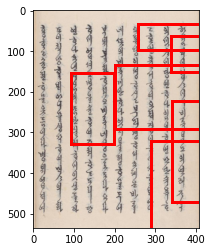

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img_)
for idx, i in enumerate(output[0][0]):
    x,y,w,h,confi = i
    rect = patches.Rectangle((x,y),w,h, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    if idx == 5:
        break
